
## SFFD - Calls for Service ##

### Machine Learning Explorations ###

Our machine learning goals are two-fold. First we want to see if we can extract enough information out of the SFFD - Calls for Service data-set to predict the response time in each neighborhood each hour in the day. Specifically we are interested to see if we can use what we know today to predict if the response time in a district will be better or worse than usual tomorrow.
The second goal is to extract what of the features we look at are the most defining, which features stick out.

First we read in the general first responder dataset we've already created in the data wrangling notebook. We skip the Non Life-threatening responds and focus on the respones to fire and potentially life-threatening medical situations, we also perform any extra data wrangling we might need.

In [18]:
import numpy as np
import pandas as pd

data = pd.read_json('general_data.json')
data = data[data['CallTypeGroup'].isin(['Alarm','Fire','Potentially Life-Threatening'])]
data = data[data['NeighborhoodDistrict'] != 'None']
data = data[data['ReceivedHour'] != -1]

In [19]:
day_averages = data[data['ReceivedHour']!= -1][['CallDate','frTimeToArrival', 'StationDispatches','Station24HrDispatches','Station48to24HrDispatches']].groupby(['CallDate']).mean().reset_index()
day_hour_averages = data[data['ReceivedHour']!= -1][['ReceivedHour','frTimeToArrival', 'StationDispatches','Station24HrDispatches','Station48to24HrDispatches']].groupby(['ReceivedHour']).mean().reset_index()
dispatch_average = data[data['ReceivedHour']!= -1][['CallDate','StationDispatches','Station24HrDispatches','Station48to24HrDispatches']].groupby(['CallDate']).sum().reset_index().mean()

In [40]:
daily_dispatch_deviation = data[data['ReceivedHour']!= -1][['CallDate','StationDispatches']].groupby(['CallDate']).sum().reset_index()
daily_dispatch_deviation['StationDispatches'] = daily_dispatch_deviation['StationDispatches']-daily_dispatch_deviation['StationDispatches'].mean()
daily_dispatch_deviation = daily_dispatch_deviation.groupby('CallDate').mean().to_dict()['StationDispatches']
data['Hourly_StationDispatchDiff'] = [sd-day_hour_averages['StationDispatches'].iloc[hr] for sd,hr in data[['StationDispatches','ReceivedHour']].values]
daily_24Hrdispatch_deviation = data[data['ReceivedHour']!= -1][['CallDate','Station24HrDispatches']].groupby(['CallDate']).sum().reset_index()
daily_24Hrdispatch_deviation['Station24HrDispatches'] = daily_24Hrdispatch_deviation['Station24HrDispatches']-daily_24Hrdispatch_deviation['Station24HrDispatches'].mean()
daily_24Hrdispatch_deviation = daily_24Hrdispatch_deviation.groupby('CallDate').mean().to_dict()['Station24HrDispatches']
data['Hourly_Station24HrDispatchDiff'] = [sd-day_hour_averages['Station24HrDispatches'].iloc[hr] for sd,hr in data[['Station24HrDispatches','ReceivedHour']].values]
daily_4824Hrdispatch_deviation = data[data['ReceivedHour']!= -1][['CallDate','Station48to24HrDispatches']].groupby(['CallDate']).sum().reset_index()
daily_4824Hrdispatch_deviation['Station48to24HrDispatches'] = daily_4824Hrdispatch_deviation['Station48to24HrDispatches']-daily_4824Hrdispatch_deviation['Station48to24HrDispatches'].mean()
daily_4824Hrdispatch_deviation = daily_4824Hrdispatch_deviation.groupby('CallDate').mean().to_dict()['Station48to24HrDispatches']
data['Hourly_Station4824HrDispatchDiff'] = [sd-day_hour_averages['Station48to24HrDispatches'].iloc[hr] for sd,hr in data[['Station48to24HrDispatches','ReceivedHour']].values]

Above we've calculated difference in dispatches from the average. We have three moving windows of station dispatches in the dataset. The first, StationDispatches contains the total number of dispatches from a station in the last 60 minutes when a call serverd by that station is received. The second, Station24HrDispatches contains the total number of dispatches from a station in the last 24 hours when a call served by that station is received and finally Station48to24HrDispatches contains the total number of dispatches in the 48 to 24 hour window, that is, the total in the 24 hours after the first 24 hours.

We calculate the dispatch difference on an hour by hour basis. This means we have the workload on each station in the last hour when a call gets assigned to it and how different it is from the workload for that station in that hour on average. We also have the station dispatches in the last 24 hours and how different they are from the average as well as the 24 our window prior to that. This means that if we use the hourly difference of the totals we eliminate the natural variance between the hours of the day. The dispatch sums also contain the dispatches for non life-threatening calls. 

We can look at why and when we might want this by plotting the sum of arrival times and the sum of station dispatches against the hour of the day the call was received.

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
sub = data[['ReceivedHour','frTimeToArrival', 'StationDispatches']].groupby(['ReceivedHour']).sum().reset_index()
fig, ax1 = plt.subplots()
fig.tight_layout()

fig.set_size_inches(20,10)
ax1.plot(sub.index,sub.ix[:,1],'o',label='Total time to arrival')
ax2 = ax1.twinx()
ax2.plot(sub.index,sub.ix[:,2],'o',color='Orange',label='Total station dispatches')
plt.show()

We see that even if the magnitude is different they correlate pretty much perfectly. Now we can look at the difference instead.

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
sub = data[['ReceivedHour','frTimeToArrival', 'Hourly_StationDispatchDiff']].groupby(['ReceivedHour']).sum().reset_index()
fig, ax1 = plt.subplots()
fig.tight_layout()

fig.set_size_inches(20,10)
ax1.plot(sub.ix[:,0],sub.ix[:,1],'o',label='Total time to arrival')
ax2 = ax1.twinx()
ax2.plot(sub.ix[:,0],sub.ix[:,2],'o',color='Orange',label='Total station dispatches')
plt.show()

Now when we sum up the difference we get almost a straight line around zero. It doesn't look like it but remember that we have two axes here and if we look at magnitude of the second axis shown at the top we see it's $1e^{-9}$ so the large jump we see at 13 is actually $1.2*10^{-9}$ which means it's actually very close to zero. The same thing can be said about the other two dispatch total windows.

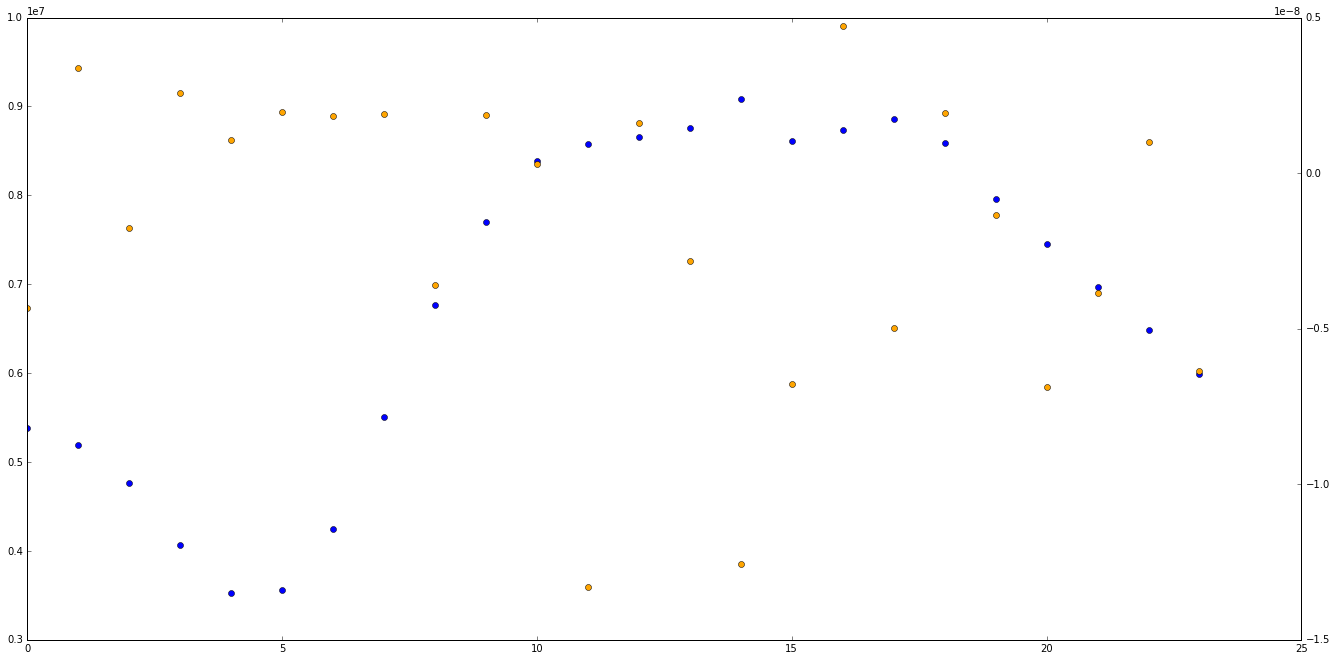

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
sub = data[['ReceivedHour','frTimeToArrival', 'Hourly_Station24HrDispatchDiff']].groupby(['ReceivedHour']).sum().reset_index()
fig, ax1 = plt.subplots()
fig.tight_layout()

fig.set_size_inches(20,10)
ax1.plot(sub.index,sub.ix[:,1],'o',label='Total time to arrival')
ax2 = ax1.twinx()
ax2.plot(sub.index,sub.ix[:,2],'o',color='Orange',label='Total station dispatches')
plt.show()

We have a few categorical features, pandas allows us to cast them as special categorical types which we can then use to easily do what's called one-hot encoding. That essentially means that we expand the categorical columns so that the question "does this observations belong in this class" get´s answered by a series of yes and no columns. We do what is called K-1 hot encoding. That means that when all the generated replacement columns for that categorical column are False or 0 then that observation belongs to a column that doesn´t get it´s own one-hot encoding column. This is to avoid co-linearity.

In [41]:
# Casting categorical columns as categorical.
for col in ['Battalion','CallType','CallTypeGroup','NeighborhoodDistrict','StationArea']:
    data[col] = pd.Categorical(data[col], categories=data[col].unique())

In [43]:
## imports for Machine Learning Explorations
from __future__ import division
from collections import Counter
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, TransformerMixin
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR,SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import pyglet
import geoplotlib
from geoplotlib.utils import BoundingBox
from matplotlib import cm
from sklearn.mixture import GaussianMixture
%matplotlib inline
pd.set_option('display.max_columns', 100)

First we want to see if we can predict the response time in seconds at the hour the call is received. The models we want to try are specifically for this are KNN and RandomForest. Since we have a lot of data to work with we will not use cross validation. We will measure the mean squared error of the model and compare it to the mean squared of guessing the mean time to arrival every time. First we will evaluate using only 2016 and if we manage to train a model that tests better that the mean then we will train it further on all the data and evaluate it on new data for the year 2017.

In [59]:
# Predicting time to arrival for neighborhood and hour of day, tomorrow.
# subs = data[(data['ReceivedYear'] == 2016)&(data['NeighborhoodDistrict'] == 'Mission')][['CallTypeGroup','frTimeToArrival','ReceivedHour','Box']].reset_index(drop=True)
subs = data[(data['ReceivedYear'].isin([2016]))][['Weekend', 'NeighborhoodDistrict', 'CallType','frTimeToArrival','ReceivedHour','StationArea','Hourly_Station24HrDispatchDiff']].reset_index(drop=True)

def _scale_stuff(X):
    """ Requires a global pandas dataframe subs.
        Finds the mean and reduces the variance of hot-encoded classes 
        based on the number of different types in each
        class. For K class types we assume their are K-1 columns."""
    X_ = X - np.ones((X.shape[0],1))*X.mean(0)
    for i,col in enumerate(subs.drop('frTimeToArrival',axis=1).columns):
        if 'Neighborhood' in col:
            X_[i]/(subs['NeighborhoodDistrict'].nunique()-1)
        if 'CallType' in col:
            X_[i]/(subs['CallType'].nunique()-1)
        if 'CallTypeGroup' in col:
            X_[i]/(subs['CallTypeGroup'].nunique()-1)
        if 'StationArea' in col:
            X_[i]/(subs['StationArea'].nunique()-1)
        if 'CallTypeGroup' in col:
            X_[i]/(subs['CallTypeGroup'].nunique()-1)
        if 'Box' in col:
            X_[i]/(subs['Box'].nunique()-1)
        if 'Battalion' in col:
            X_[i]/(subs['Battalion'].nunique()-1)
    return X_

# Drop the column we want to predict
X = subs.drop('frTimeToArrival',axis=1)
# expand the training data so each class column gets turned into K-1 columns, where K is
# the number of different class types. We create K-1 columns to avoid co-linearity.
X_ = pd.get_dummies(X,drop_first=True) 

# Modify the column if we want to.
# Here we turn the time to arrival column into integer values representing minutes.
# subs['frTimeToArrival'] = (subs['frTimeToArrival']/60).round()
y = subs['frTimeToArrival'] #predicting time to arrival 
y = y.values

# We decided to do a simple training/test split with 20% as the test data.
# Cross-validating would take too long for KNN and Support Vector Machine models.
X_train, X_test, y_train, y_test = train_test_split(X_, y,test_size=0.2)
scaler = MinMaxScaler(feature_range=(-3,3))
X_train_ = scaler.fit_transform(_scale_stuff(X_train.as_matrix()))

Mean squared model: 4.42207222319
Mean squared mean: 3.75650576227


In [ ]:
# First we try the random forest model.
lm = RandomForestRegressor(n_estimators=100)
lm.fit(X_train_, y_train)
lm_prediction = lm.predict(scaler.transform(_scale_stuff(X_test.as_matrix())))
c = mean_squared_error(y_test,lm_prediction)
training_mean = y_train.mean()
c1 = mean_squared_error(y_test,np.array([training_mean for x in range(lm_prediction.shape[0])]))
print "Mean squared model:", c/(lm_prediction.shape[0])
print "Mean squared mean:", c1/(lm_prediction.shape[0])

We see that a RandomForest regressor fails to beat guessing the mean. We have a lot of categorical data which means that the random forest classifier, due to it's design, might look past relevant classes too often. We now try the same thing with a KNN model.

In [62]:
Kay = int(np.sqrt(X_train.shape[0])/2)
if Kay%2==0: # All the superstitions
    Kay = Kay-1
lm = KNeighborsRegressor(Kay)
lm.fit(X_train_, y_train)
lm_prediction = lm.predict(scaler.transform(_scale_stuff(X_test.as_matrix())))
c = mean_squared_error(y_test,lm_prediction)
training_mean = y_train.mean()
c1 = mean_squared_error(y_test,np.array([training_mean for x in range(lm_prediction.shape[0])]))
print "Mean squared model:", c/(lm_prediction.shape[0])
print "Mean squared mean:", c1/(lm_prediction.shape[0])

Mean squared model: 3.57066162599
Mean squared mean: 3.75650576227


We've managed to train a KNN model that performs slightly better than predicting the mean. Now we're interested in seeing what happens if we change the prediction to minutes. Answering in seconds is not ideal when the prediction is an order of magnitude away from the actual value. First we give the RandomForest regressor another shot.

In [66]:
# First we try the random forest model.
subs['frTimeToArrival_minutes'] = (subs['frTimeToArrival']/60).round()
y = subs['frTimeToArrival_minutes'].values
X_train, X_test, y_train, y_test = train_test_split(X_, y,test_size=0.2)
scaler = MinMaxScaler(feature_range=(-3,3))
X_train_ = scaler.fit_transform(_scale_stuff(X_train.as_matrix()))
lm = RandomForestRegressor(n_estimators=100)
lm.fit(X_train_, y_train)
lm_prediction = lm.predict(scaler.transform(_scale_stuff(X_test.as_matrix())))
c = mean_squared_error(y_test,lm_prediction)
training_mean = y_train.mean()
mean_arr = np.array([training_mean for x in range(lm_prediction.shape[0])])
c1 = mean_squared_error(y_test,mean_arr)
print "Mean squared model:", c/(lm_prediction.shape[0])
print "Mean squared mean:", c1/(lm_prediction.shape[0])

Mean squared model: 0.00144326277475
Mean squared mean: 0.00125082583422


Again the Random Forest model misses it's mark, we can look at the first 10 tested y, along with the prediction and the mean.

In [76]:
zip(y_test,np.round(lm_prediction,2),np.round(np.array([training_mean for x in range(lm_prediction.shape[0])]),2))[:10]

[(4.0, 13.24, 6.54),
 (7.0, 7.7699999999999996, 6.54),
 (6.0, 7.4900000000000002, 6.54),
 (2.0, 3.75, 6.54),
 (5.0, 7.8899999999999997, 6.54),
 (6.0, 4.54, 6.54),
 (5.0, 6.2199999999999998, 6.54),
 (5.0, 10.210000000000001, 6.54),
 (19.0, 8.0199999999999996, 6.54),
 (3.0, 3.2000000000000002, 6.54)]

Now for KNN.

In [79]:
Kay = int(np.sqrt(X_train.shape[0])/2)
if Kay%2==0: # All the superstitions
    Kay = Kay-1
lm = KNeighborsRegressor(Kay)
lm.fit(X_train_, y_train)
lm_prediction = lm.predict(scaler.transform(_scale_stuff(X_test.as_matrix())))
c = mean_squared_error(y_test,lm_prediction)
training_mean = y_train.mean()
mean_arr = np.array([training_mean for x in range(lm_prediction.shape[0])])
c1 = mean_squared_error(y_test,mean_arr)
print "Mean squared model:", c/(lm_prediction.shape[0])
print "Mean squared mean:", c1/(lm_prediction.shape[0])

Mean squared model: 0.00118881689405
Mean squared mean: 0.00125082583422


In [81]:
zip(y_test,np.round(lm_prediction,2),np.round(np.array([training_mean for x in range(lm_prediction.shape[0])]),2))[:10]

[(4.0, 8.2300000000000004, 6.54),
 (7.0, 8.0600000000000005, 6.54),
 (6.0, 7.0700000000000003, 6.54),
 (2.0, 4.4299999999999997, 6.54),
 (5.0, 7.2000000000000002, 6.54),
 (6.0, 6.9900000000000002, 6.54),
 (5.0, 5.7400000000000002, 6.54),
 (5.0, 7.6799999999999997, 6.54),
 (19.0, 7.8799999999999999, 6.54),
 (3.0, 3.3199999999999998, 6.54),
 (4.0, 4.9100000000000001, 6.54),
 (11.0, 7.3099999999999996, 6.54),
 (7.0, 7.9699999999999998, 6.54),
 (5.0, 8.0999999999999996, 6.54),
 (5.0, 6.71, 6.54),
 (3.0, 5.1299999999999999, 6.54),
 (6.0, 6.0, 6.54),
 (4.0, 6.9299999999999997, 6.54),
 (7.0, 5.46, 6.54),
 (3.0, 4.7199999999999998, 6.54)]

We see that our predictor is in most cases a real number while the minutes are ofcourse integers. So what if we look at this as a classifying problem instead?

In [82]:
Kay = int(np.sqrt(X_train.shape[0])/2)
if Kay%2==0: # All the superstitions
    Kay = Kay-1
lm = KNeighborsClassifier(Kay)
lm.fit(X_train_, y_train)
lm_prediction = lm.predict(scaler.transform(_scale_stuff(X_test.as_matrix())))
c = mean_squared_error(y_test,lm_prediction)
training_mean = y_train.mean()
mean_arr = np.array([training_mean for x in range(lm_prediction.shape[0])])
c1 = mean_squared_error(y_test,mean_arr)
print "Mean squared model:", c/(lm_prediction.shape[0])
print "Mean squared mean:", c1/(lm_prediction.shape[0])

Mean squared model: 0.00137285233673
Mean squared mean: 0.00125082583422


In [83]:
zip(y_test,np.round(lm_prediction,2),np.round(np.array([training_mean for x in range(lm_prediction.shape[0])]),2))[:10]

[(4.0, 5.0, 6.54),
 (7.0, 5.0, 6.54),
 (6.0, 5.0, 6.54),
 (2.0, 4.0, 6.54),
 (5.0, 5.0, 6.54),
 (6.0, 6.0, 6.54),
 (5.0, 4.0, 6.54),
 (5.0, 5.0, 6.54),
 (19.0, 6.0, 6.54),
 (3.0, 3.0, 6.54)]

Let's look at the missclassification rate. The mean squared error actually is applicaple here because we are actually interested in the measurable differences, but let's see how often we are dead on the money.

In [84]:
pred_miss_counter = Counter(y_test==lm_prediction)
most_common = sorted(Counter(y_train).iteritems(), key=lambda x: x[1], reverse=True)[0][0]
mean_miss_counter = Counter(y_test==np.array([most_common for x in range(lm_prediction.shape[0])]))
print "Model classification rate:", pred_miss_counter[True]/(lm_prediction.shape[0])
print "Most common classification rate:", mean_miss_counter[True]/(lm_prediction.shape[0])

Model classification rate: 0.225561813417
Most common classification rate: 0.201137567613


We see that we are dead on the money 22.5% of the time but the mean is actually dead on the money 20% of the time which means we are just a little better. From the few samples we've seen it looks like our model might be very bad at predicting outliers so let's group everything above 10 minutes together.

In [87]:
y = subs['frTimeToArrival_minutes'] #predicting time to arrival classes
y.loc[y>=10] = 10
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X_, y,test_size=0.2)
scaler = MinMaxScaler(feature_range=(-3,3))
X_train_ = scaler.fit_transform(_scale_stuff(X_train.as_matrix()))
Kay = int(np.sqrt(X_train.shape[0])/2)
if Kay%2==0: # All the superstitions
    Kay = Kay-1
lm = KNeighborsClassifier(Kay)
lm.fit(X_train_, y_train)
lm_prediction = lm.predict(scaler.transform(_scale_stuff(X_test.as_matrix())))
c = mean_squared_error(y_test,lm_prediction)
training_mean = y_train.mean()
mean_arr = np.array([training_mean for x in range(lm_prediction.shape[0])])
c1 = mean_squared_error(y_test,mean_arr)
print "Mean squared model:", c/(lm_prediction.shape[0])
print "Mean squared mean:", c1/(lm_prediction.shape[0])

C:\Anaconda2\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Mean squared model: 0.000385581144589
Mean squared mean: 0.000294243986725


In [88]:
pred_miss_counter = Counter(y_test==lm_prediction)
most_common = sorted(Counter(y_train).iteritems(), key=lambda x: x[1], reverse=True)[0][0]
mean_miss_counter = Counter(y_test==np.array([most_common for x in range(lm_prediction.shape[0])]))
print "Model classification rate:", pred_miss_counter[True]/(lm_prediction.shape[0])
print "Most common classification rate:", mean_miss_counter[True]/(lm_prediction.shape[0])

Model classification rate: 0.22868454804
Most common classification rate: 0.199743489656


Even if we managed to decrease the Mean squared error the classifications stayed the same.

In [95]:
zip(y_test,np.round(lm_prediction,2),np.array([most_common for x in range(lm_prediction.shape[0])]))[:10]

[(6.0, 5.0, 5.0),
 (5.0, 5.0, 5.0),
 (6.0, 4.0, 5.0),
 (10.0, 5.0, 5.0),
 (6.0, 5.0, 5.0),
 (5.0, 5.0, 5.0),
 (9.0, 10.0, 5.0),
 (10.0, 5.0, 5.0),
 (6.0, 5.0, 5.0),
 (10.0, 5.0, 5.0)]

Even if we've managed to create a model that is consistently better than average it's not good enough to warrant training it on all the data. 

In [324]:
late_latlong = data[['Lat','Lon']].reset_index(drop=True)
clusterer_ = KMeans(10).fit(late_latlong.as_matrix())#DBSCAN(eps=10/6371., min_samples=1, algorithm='ball_tree', metric='haversine').fit(late_latlong.as_matrix())
cluster_labels = clusterer_.labels_
label_dict = Counter(cluster_labels)
# stuff = { "lat":late_latlong['Lat'].values.astype(float), "lon":late_latlong['Lon'].astype(float) }
max_lat = max(data["Lat"]) 
min_lat = min(data["Lat"])
max_lon = max(data["Lon"])
min_lon = min(data["Lon"])

print max_lat, min_lat, max_lon, min_lon
bbox = BoundingBox(north=max_lat, west=min_lon, south=min_lat, east=max_lon)
geoplotlib.set_bbox(bbox)
# geoplotlib.kde(stuff, bw= 1.5, cmap='plasma' ,cut_below=1e-6, alpha=180,method='hist')
cluster_nr = len(label_dict.keys())
if -1 in label_dict.keys():
    del label_dict[-1]
for i,p in enumerate(label_dict.keys()):
    color = [int(255*c) for c in cm.jet(i/(cluster_nr-1))[:3]]
    subset = late_latlong.iloc[cluster_labels==p]
    stuff = { "lat":subset['Lat'].values.astype(float), "lon":subset['Lon'].astype(float) }
    geoplotlib.dot(stuff, color=color)
geoplotlib.inline() 

37.8316662306 37.7082655293 -122.361474827 -122.513648359


In [332]:


late_latlong = data[(data['frTimeToArrival'] > 0)][['Lat','Lon']].reset_index(drop=True)
# late_latlong = data[['Lat','Lon']].reset_index(drop=True)
clusterer_ = GaussianMixture(10,n_init=5).fit(late_latlong.as_matrix())#DBSCAN(eps=10/6371., min_samples=1, algorithm='ball_tree', metric='haversine').fit(late_latlong.as_matrix())
cluster_labels = clusterer_.predict(late_latlong.as_matrix())
label_dict = Counter(cluster_labels)
# stuff = { "lat":late_latlong['Lat'].values.astype(float), "lon":late_latlong['Lon'].astype(float) }
max_lat = max(data["Lat"]) 
min_lat = min(data["Lat"])
max_lon = max(data["Lon"])
min_lon = min(data["Lon"])

print max_lat, min_lat, max_lon, min_lon
bbox = BoundingBox(north=max_lat, west=min_lon, south=min_lat, east=max_lon)
geoplotlib.set_bbox(bbox)
# geoplotlib.kde(stuff, bw= 1.5, cmap='plasma' ,cut_below=1e-6, alpha=180,method='hist')
cluster_nr = len(label_dict.keys())
if -1 in label_dict.keys():
    del label_dict[-1]
for i,p in enumerate(label_dict.keys()):
    color = [int(255*c) for c in cm.jet(i/(cluster_nr-1))[:3]]
    subset = late_latlong.iloc[cluster_labels==p]
    stuff = { "lat":subset['Lat'].values.astype(float), "lon":subset['Lon'].astype(float) }
    geoplotlib.dot(stuff, color=color)
geoplotlib.inline() 

37.8316662306 37.7082655293 -122.361474827 -122.513648359


In [448]:
subs = data[data['ReceivedYear']==2016]
X = pd.get_dummies(subs[['Weekend', 'NeighborhoodDistrict', 'CallType', 'CallTypeGroup','frTimeToArrival','ReceivedHour','StationArea', 'Box', 'Battalion']])

late_latlong = subs[['Lat','Lon']].reset_index(drop=True)
# late_latlong = data[['Lat','Lon']].reset_index(drop=True)
clusterer_ = GaussianMixture(10,n_init=1).fit(X.as_matrix())#DBSCAN(eps=10/6371., min_samples=1, algorithm='ball_tree', metric='haversine').fit(late_latlong.as_matrix())
cluster_labels = clusterer_.predict(X.as_matrix())
label_dict = Counter(cluster_labels)
# stuff = { "lat":late_latlong['Lat'].values.astype(float), "lon":late_latlong['Lon'].astype(float) }
max_lat = max(data["Lat"]) 
min_lat = min(data["Lat"])
max_lon = max(data["Lon"])
min_lon = min(data["Lon"])

print max_lat, min_lat, max_lon, min_lon
bbox = BoundingBox(north=max_lat, west=min_lon, south=min_lat, east=max_lon)
geoplotlib.set_bbox(bbox)
# geoplotlib.kde(stuff, bw= 1.5, cmap='plasma' ,cut_below=1e-6, alpha=180,method='hist')
cluster_nr = len(label_dict.keys())
if -1 in label_dict.keys():
    del label_dict[-1]
for i,p in enumerate(label_dict.keys()):
    color = [int(255*c) for c in cm.jet(i/(cluster_nr-1))[:3]]
    subset = late_latlong.iloc[cluster_labels==p]
    stuff = { "lat":subset['Lat'].values.astype(float), "lon":subset['Lon'].astype(float) }
    geoplotlib.dot(stuff, color=color)
geoplotlib.inline() 

37.8316662306 37.7082655293 -122.361474827 -122.513648359


In [9]:
subs = data[data['ReceivedYear']==2016]
X = pd.get_dummies(subs[['Weekend', 'NeighborhoodDistrict', 'CallType', 'CallTypeGroup','frTimeToArrival','ReceivedHour','StationArea', 'Box', 'Battalion']])

late_latlong = subs[['Lat','Lon']].reset_index(drop=True)
# late_latlong = data[['Lat','Lon']].reset_index(drop=True)
clusterer_ = KMeans(10,n_init=5).fit(X.as_matrix())#DBSCAN(eps=10/6371., min_samples=1, algorithm='ball_tree', metric='haversine').fit(late_latlong.as_matrix())
cluster_labels = clusterer_.predict(X.as_matrix())
label_dict = Counter(cluster_labels)
# stuff = { "lat":late_latlong['Lat'].values.astype(float), "lon":late_latlong['Lon'].astype(float) }
max_lat = max(data["Lat"]) 
min_lat = min(data["Lat"])
max_lon = max(data["Lon"])
min_lon = min(data["Lon"])

print max_lat, min_lat, max_lon, min_lon
bbox = BoundingBox(north=max_lat, west=min_lon, south=min_lat, east=max_lon)
geoplotlib.set_bbox(bbox)
# geoplotlib.kde(stuff, bw= 1.5, cmap='plasma' ,cut_below=1e-6, alpha=180,method='hist')
cluster_nr = len(label_dict.keys())
if -1 in label_dict.keys():
    del label_dict[-1]
for i,p in enumerate(label_dict.keys()):
    color = [int(255*c) for c in cm.jet(i/(cluster_nr-1))[:3]]
    subset = late_latlong.iloc[cluster_labels==p]
    stuff = { "lat":subset['Lat'].values.astype(float), "lon":subset['Lon'].astype(float) }
    geoplotlib.dot(stuff, color=color)
geoplotlib.inline() 

37.8316662306 37.7082655293 -122.361474827 -122.513648359


In [61]:
subs = data[data['ReceivedYear'].isin([2016])]
scaler = MinMaxScaler(feature_range=(-3,3))
X = pd.get_dummies(subs[['NeighborhoodDistrict', 'CallType','frTimeToArrival','ReceivedHour','StationArea', 'Box', 'Battalion']],drop_first=True)
X_ = scaler.fit_transform((X-X.mean()).as_matrix()) #/scaler.fit_transform(X.as_matrix())

for i,col in enumerate(X.columns):
    if 'Neighborhood' in col:
        X_[i]/subs['NeighborhoodDistrict'].nunique()
    if 'CallType' in col:
        X_[i]/subs['CallType'].nunique()
    if 'CallTypeGroup' in col:
        X_[i]/subs['CallTypeGroup'].nunique()
    if 'StationArea' in col:
        X_[i]/subs['StationArea'].nunique()
    if 'CallTypeGroup' in col:
        X_[i]/subs['CallTypeGroup'].nunique()
    if 'Box' in col:
        X_[i]/subs['Box'].nunique()
    if 'Battalion' in col:
        X_[i]/subs['Battalion'].nunique()

late_latlong = subs[['Lat','Lon']].reset_index(drop=True)
# late_latlong = data[['Lat','Lon']].reset_index(drop=True)
clusterer_ = KMeans(2,n_init=5).fit(X_)#DBSCAN(eps=10/6371., min_samples=1, algorithm='ball_tree', metric='haversine').fit(late_latlong.as_matrix())
cluster_labels = clusterer_.predict(X_)
label_dict = Counter(cluster_labels)
# stuff = { "lat":late_latlong['Lat'].values.astype(float), "lon":late_latlong['Lon'].astype(float) }
max_lat = max(data["Lat"]) 
min_lat = min(data["Lat"])
max_lon = max(data["Lon"])
min_lon = min(data["Lon"])

print max_lat, min_lat, max_lon, min_lon
bbox = BoundingBox(north=max_lat, west=min_lon, south=min_lat, east=max_lon)
geoplotlib.set_bbox(bbox)
# geoplotlib.kde(stuff, bw= 1.5, cmap='plasma' ,cut_below=1e-6, alpha=180,method='hist')
cluster_nr = len(label_dict.keys())
if -1 in label_dict.keys():
    del label_dict[-1]
for i,p in enumerate(label_dict.keys()):
    color = [int(255*c) for c in cm.jet(i/(cluster_nr-1))[:3]]
    subset = late_latlong.iloc[cluster_labels==p]
    stuff = { "lat":subset['Lat'].values.astype(float), "lon":subset['Lon'].astype(float) }
    geoplotlib.dot(stuff, color=color)
geoplotlib.inline() 

37.8316662306 37.7082655293 -122.361474827 -122.513648359


In [62]:
zip(cluster_labels,subs['CallTypeGroup'])

[(1, u'Potentially Life-Threatening'),
 (0, u'Fire'),
 (1, u'Potentially Life-Threatening'),
 (0, u'Fire'),
 (1, u'Potentially Life-Threatening'),
 (1, u'Potentially Life-Threatening'),
 (1, u'Potentially Life-Threatening'),
 (0, u'Alarm'),
 (0, u'Alarm'),
 (1, u'Potentially Life-Threatening'),
 (0, u'Fire'),
 (1, u'Potentially Life-Threatening'),
 (1, u'Potentially Life-Threatening'),
 (1, u'Potentially Life-Threatening'),
 (0, u'Alarm'),
 (1, u'Potentially Life-Threatening'),
 (1, u'Potentially Life-Threatening'),
 (0, u'Alarm'),
 (1, u'Potentially Life-Threatening'),
 (1, u'Potentially Life-Threatening'),
 (1, u'Potentially Life-Threatening'),
 (0, u'Alarm'),
 (1, u'Potentially Life-Threatening'),
 (1, u'Potentially Life-Threatening'),
 (1, u'Potentially Life-Threatening'),
 (1, u'Potentially Life-Threatening'),
 (0, u'Fire'),
 (1, u'Potentially Life-Threatening'),
 (1, u'Potentially Life-Threatening'),
 (1, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (

In [67]:
subs = data[data['ReceivedYear'].isin([2016])]
scaler = MinMaxScaler(feature_range=(-3,3))
X = pd.get_dummies(subs[['NeighborhoodDistrict', 'CallType','CallTypeGroup', 'frTimeToArrival','ReceivedHour','StationArea', 'Box', 'Battalion']],drop_first=True)
X_ = scaler.fit_transform((X-X.mean()).as_matrix()) #/scaler.fit_transform(X.as_matrix())

for i,col in enumerate(X.columns):
    if 'Neighborhood' in col:
        X_[i]/subs['NeighborhoodDistrict'].nunique()
    if 'CallType' in col:
        X_[i]/subs['CallType'].nunique()
    if 'CallTypeGroup' in col:
        X_[i]/subs['CallTypeGroup'].nunique()
    if 'StationArea' in col:
        X_[i]/subs['StationArea'].nunique()
    if 'CallTypeGroup' in col:
        X_[i]/subs['CallTypeGroup'].nunique()
    if 'Box' in col:
        X_[i]/subs['Box'].nunique()
    if 'Battalion' in col:
        X_[i]/subs['Battalion'].nunique()

late_latlong = subs[['Lat','Lon']].reset_index(drop=True)
# late_latlong = data[['Lat','Lon']].reset_index(drop=True)
clusterer_ = GaussianMixture(2,n_init=5).fit(X_)#DBSCAN(eps=10/6371., min_samples=1, algorithm='ball_tree', metric='haversine').fit(late_latlong.as_matrix())
cluster_labels = clusterer_.predict(X_)
label_dict = Counter(cluster_labels)
# stuff = { "lat":late_latlong['Lat'].values.astype(float), "lon":late_latlong['Lon'].astype(float) }
max_lat = max(data["Lat"]) 
min_lat = min(data["Lat"])
max_lon = max(data["Lon"])
min_lon = min(data["Lon"])

print max_lat, min_lat, max_lon, min_lon
bbox = BoundingBox(north=max_lat, west=min_lon, south=min_lat, east=max_lon)
geoplotlib.set_bbox(bbox)
# geoplotlib.kde(stuff, bw= 1.5, cmap='plasma' ,cut_below=1e-6, alpha=180,method='hist')
cluster_nr = len(label_dict.keys())
if -1 in label_dict.keys():
    del label_dict[-1]
for i,p in enumerate(label_dict.keys()):
    color = [int(255*c) for c in cm.jet(i/(cluster_nr-1))[:3]]
    subset = late_latlong.iloc[cluster_labels==p]
    stuff = { "lat":subset['Lat'].values.astype(float), "lon":subset['Lon'].astype(float) }
    geoplotlib.dot(stuff, color=color)
geoplotlib.inline() 

37.8316662306 37.7082655293 -122.361474827 -122.513648359


In [68]:
zip(cluster_labels,subs['CallTypeGroup'])

[(0, u'Potentially Life-Threatening'),
 (1, u'Fire'),
 (0, u'Potentially Life-Threatening'),
 (1, u'Fire'),
 (0, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (1, u'Alarm'),
 (1, u'Alarm'),
 (0, u'Potentially Life-Threatening'),
 (1, u'Fire'),
 (0, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (1, u'Alarm'),
 (0, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (1, u'Alarm'),
 (0, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (1, u'Alarm'),
 (0, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (1, u'Fire'),
 (0, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (0, u'Potentially Life-Threatening'),
 (